In [1]:
import datetime
import os
import re
import csv
from lib_log_parse import load_parsed_logs, parse
from typing import List, Optional
import numpy as np
from lib_constants import log_no_to_region
from model_publication import Publication
from model_retrieval import Retrieval
import multiprocessing as mp
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_theme()

In [2]:
def cdf(series: pd.Series) -> pd.DataFrame:
    return pd.DataFrame.from_dict({
        series.name: np.append(series.sort_values(), series.max()),
        "cdf": np.linspace(0, 1, len(series) + 1)
    })

In [3]:
times = []
with open('../data/find-times.csv') as csvfile:
     rows = csv.reader(csvfile, delimiter=',')
     for row in rows:
         times += [float(row[1])]
times = cdf(pd.Series(times, name="durations"))

In [4]:
log_paths = [
    "../data/2023-01-31_plain",
    "../data/2023-01-31_ignore_gala",
]

In [8]:
for path in log_paths:
    values = []
    for fn in os.listdir(path):
        file_path = os.path.join(path, fn)
        if not os.path.isfile(file_path):
            continue

        if not fn.endswith(".log"):
            continue

        if os.path.exists(file_path + ".p"):
            print(f"Skipping: {file_path}")
            continue

        parse([file_path])
        # values += [[file_path]]

    # with mp.Pool() as pool:
    #     pool.map(parse, values)

Skipping: ../data/2023-01-31_plain/plain-node-5.log
Skipping: ../data/2023-01-31_plain/plain-node-4.log
Skipping: ../data/2023-01-31_plain/plain-node-3.log
Skipping: ../data/2023-01-31_plain/plain-node-2.log
Skipping: ../data/2023-01-31_plain/plain-node-0.log
Skipping: ../data/2023-01-31_plain/plain-node-1.log
Skipping: ../data/2023-01-31_ignore_gala/ignore-gala-node-4.log
Skipping: ../data/2023-01-31_ignore_gala/ignore-gala-node-5.log
Skipping: ../data/2023-01-31_ignore_gala/ignore-gala-node-1.log
Skipping: ../data/2023-01-31_ignore_gala/ignore-gala-node-0.log
Skipping: ../data/2023-01-31_ignore_gala/ignore-gala-node-2.log
Parsing ../data/2023-01-31_ignore_gala/ignore-gala-node-3.log
Resetting retrieval for QmWmyEyCtKbQ99faWY7ShD6buABeKasmbGUnXmKofiSQiU
Resetting retrieval for QmboMnR9hc15NidjfMwcirXyH2BFQPB16w9VaAoTk9Ry5U
Resetting retrieval for QmVHxMTbtBRSn9t1xR2xEzq4MfbNRnXd9DehxpYasNCEAF
Resetting retrieval for QmQkJob8qHpLqksrD6ALAPezMcByB9ygE3az2P4XSfsBAn
Unstarted query ended 

In [9]:
results_map = {}
files_map = {}
for i, path in enumerate(log_paths):
    files = []
    for fn in os.listdir(path):
        file_path = os.path.join(path, fn)
        if not os.path.isfile(file_path):
            continue

        if not fn.endswith(".log"):
            continue

        files += [file_path]

    pool = mp.Pool(mp.cpu_count())
    results = pool.map(load_parsed_logs, list(map(lambda x: [x], files)))
    if i == 0:
        results_map["with_gala"] = results
        files_map["with_gala"] = files
    elif i == 1:
        results_map["without_gala"] = results
        files_map["without_gala"] = files
    else:
        results_map["alpha_20"] = results
        files_map["alpha_20"] = files


log_files ['../data/2023-01-31_plain/plain-node-2.log']
Loading  ../data/2023-01-31_plain/plain-node-2.log
Took 0:00:10.039297
log_files ['../data/2023-01-31_plain/plain-node-1.log']
Loading  ../data/2023-01-31_plain/plain-node-1.log
Took 0:00:09.998895
log_files ['../data/2023-01-31_plain/plain-node-5.log']
Loading  ../data/2023-01-31_plain/plain-node-5.log
Took 0:00:12.587009
log_files ['../data/2023-01-31_plain/plain-node-0.log']
Loading  ../data/2023-01-31_plain/plain-node-0.log
Took 0:00:10.538505
log_files ['../data/2023-01-31_plain/plain-node-4.log']
Loading  ../data/2023-01-31_plain/plain-node-4.log
Took 0:00:13.111643
log_files ['../data/2023-01-31_plain/plain-node-3.log']
Loading  ../data/2023-01-31_plain/plain-node-3.log
Took 0:00:13.589533


In [11]:
def log_origin(origin: str) -> Optional[int]:
    match = re.search(r".*\/plain-node-(\d).log", origin)
    if match is None:
        match = re.search(r".*\/ignore-gala-node-(\d).log", origin)
        if match is None:
            match = re.search(r".*\/alpha-20-node-(\d).log", origin)
            if match is None:
                return None

    return int(match.group(1))

def region_from_origin(origin: str) -> str:
    node = log_origin(origin)
    return log_no_to_region[node]


results_by_region_map = {}

for key, files in files_map.items():
    results_by_region_map[key] = {}
    for idx, f in enumerate(files):
        region = region_from_origin(f)

        if not region in results_by_region_map[key]:
            results_by_region_map[key][region] = []
        results_by_region_map[key][region] += [results_map[key][idx][0]]

In [12]:
df_retrievals_dict_map ={}
df_publications_dict_map ={}
for key, files in files_map.items():
    df_publications_dict_map[key] = {
        "total_publication_duration": []
    }
    df_retrievals_dict_map[key] = {
        "node": [],
        "region": [],
        "started_at": [],
        "overall_retrieval_duration": [],
        "dht_walks_duration": [],
        "find_first_provider_duration": [],
        "connected_duration": [],
        "received_first_HAVE_duration": [],
        "content_fetch_duration": [],
        "find_provider_queries_count": [],
        "has_error": [],
    }
    publications: List[Publication] = []
    retrievals: List[Retrieval] = []
    for parsed_log in results_map[key]:
        for log in parsed_log:
            publications += log.publications
            retrievals += log.retrievals

    # Remove all retrievals that are marked as invalid
    retrievals = list(
        filter(lambda ret: not ret.marked_as_incomplete, retrievals))
    retrievals = list(filter(lambda ret: ret.state != Retrieval.State.DONE_WITHOUT_ASKING_PEERS, retrievals))

    for pub in publications:
        try:
            df_publications_dict_map[key]["total_publication_duration"] += [pub.duration_total_publication().total_seconds()]
        except:
            print("AAH")
            continue

    for ret in retrievals:
        if ret.stream_opened_at is None or ret.connected_at is None:
            print("skip", ret.stream_opened_at, ret.connected_at)
            continue

        node = log_origin(ret.origin)
        region = region_from_origin(ret.origin)
        # region = region_from_origin(ret.origin)
        if region is None:
            raise Exception("AHH")

        df_retrievals_dict_map[key]["started_at"] += [ret.dial_started_at]
        df_retrievals_dict_map[key]["node"] += [node]
        df_retrievals_dict_map[key]["region"] += [region]
        df_retrievals_dict_map[key]["has_error"] += [ret.done_retrieving_error is not None]

        overall_retrieval_duration = (ret.done_retrieving_at - ret.retrieval_started_at).total_seconds()
        # simulate peer record retrieval by adding the DHT walk duration
        overall_retrieval_duration += ret.get_dht_walk_duration()
        df_retrievals_dict_map[key]["overall_retrieval_duration"] += [overall_retrieval_duration]

        # simulate peer record retrieval by adding the DHT walk duration
        dht_walks_duration = 2 * ret.get_dht_walk_duration()
        df_retrievals_dict_map[key]["dht_walks_duration"] += [dht_walks_duration]

        df_retrievals_dict_map[key]["find_first_provider_duration"] += [(
                                                                       ret.found_first_provider_at - ret.get_providers_queries_started_at).total_seconds()]
        df_retrievals_dict_map[key]["content_fetch_duration"] += [(ret.done_retrieving_at - ret.dial_started_at).total_seconds()]
        df_retrievals_dict_map[key]["find_provider_queries_count"] += [
            len(list(filter(lambda gpq: gpq.started_at > ret.done_retrieving_at, ret.get_providers_queries.values())))]
        df_retrievals_dict_map[key]["connected_duration"] += [(ret.connected_at - ret.get_providers_queries_started_at).total_seconds()]
        df_retrievals_dict_map[key]["received_first_HAVE_duration"] += [(ret.received_first_HAVE_at - ret.get_providers_queries_started_at).total_seconds()]

    # df_retrievals = pd.DataFrame.from_dict(df_retrievals_dict_map[key])

skip None 2023-02-23 15:00:16.979165+00:00
skip None 2023-02-23 15:28:43.230886+00:00
skip None 2023-02-26 14:30:14.613928+00:00
skip None 2023-02-23 06:40:00.953254+00:00
skip None 2023-02-23 15:28:42.953744+00:00
skip None 2023-02-23 15:45:00.257851+00:00
skip None 2023-02-24 05:27:49.537496+00:00
skip None 2023-02-24 16:35:50.868574+00:00
skip None 2023-02-25 22:42:26.032663+00:00
skip None 2023-02-27 17:13:56.922774+00:00
skip None 2023-02-27 14:46:52.728466+00:00
skip None 2023-02-23 06:40:01.695396+00:00
skip None 2023-02-23 15:28:43.137612+00:00
skip None 2023-02-26 14:30:15.159323+00:00
skip None 2023-02-24 15:12:30.526246+00:00
skip None 2023-02-22 11:10:39.047740+00:00
skip None 2023-02-22 05:29:14.545872+00:00
skip None 2023-02-24 07:21:14.275209+00:00
skip None 2023-02-27 05:35:31.811678+00:00
skip None 2023-02-24 23:28:31.734920+00:00
skip None 2023-02-27 09:25:57.120373+00:00
skip None 2023-02-22 23:19:47.267235+00:00
skip None 2023-02-26 01:53:37.631718+00:00
skip None 2

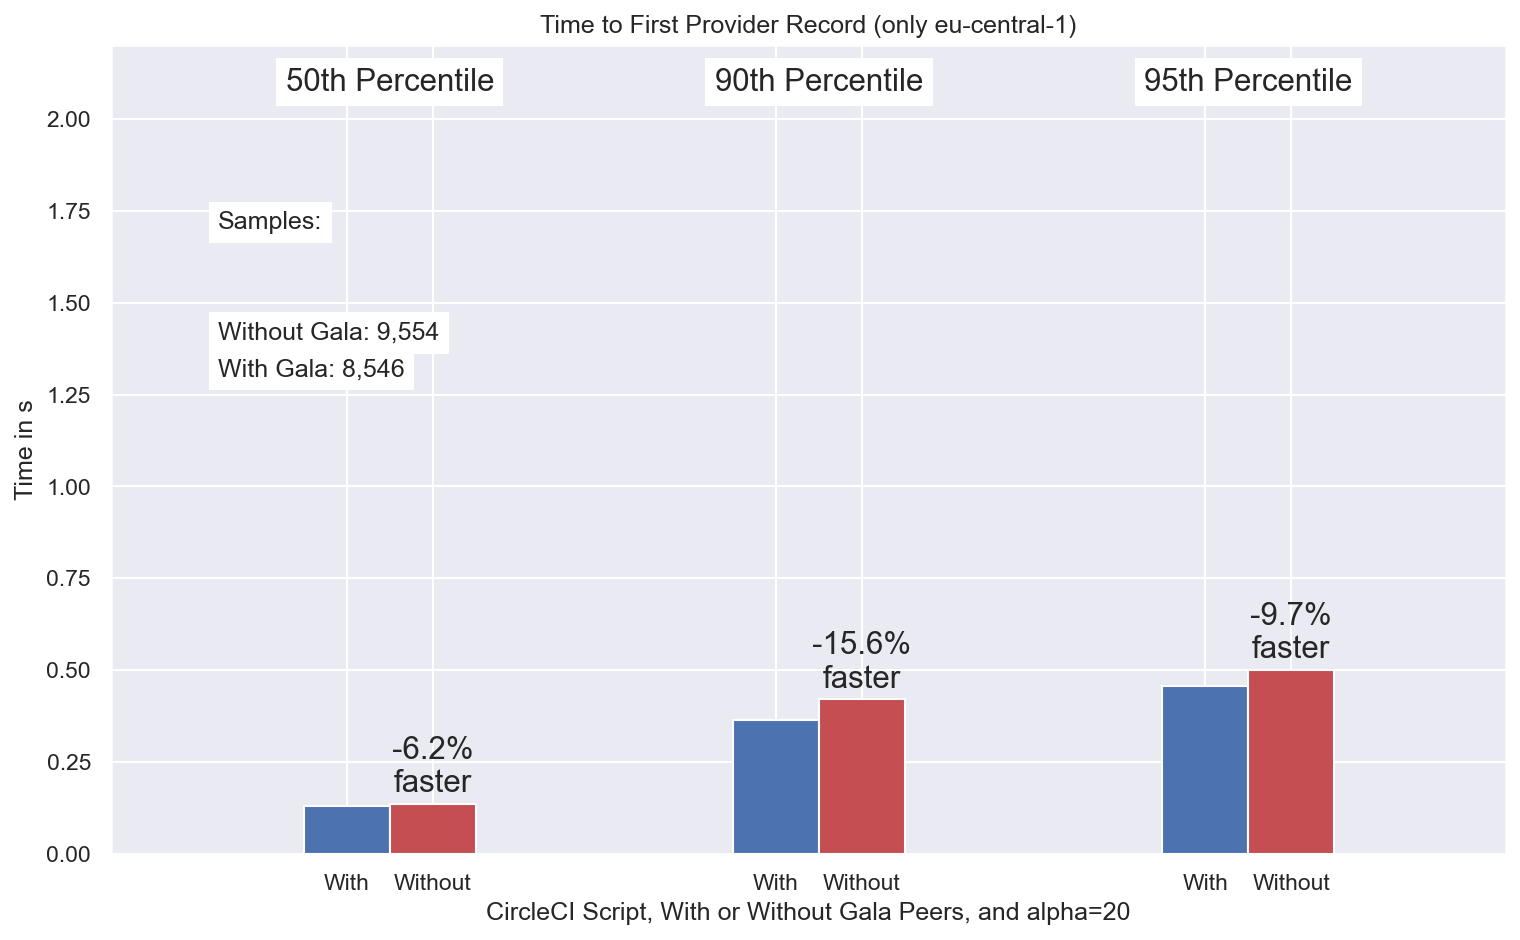

In [13]:
width = 0.2

fig, ax = plt.subplots(figsize=[12, 7], dpi=150)

xticks = []
labels = []
retrievals_by_galas = {
    "with": pd.DataFrame.from_dict(df_retrievals_dict_map["with_gala"]),
    "without": pd.DataFrame.from_dict(df_retrievals_dict_map["without_gala"]),
}
min_date = retrievals_by_galas["with"]["started_at"].min()
region = "eu_central_1"
sample_counts = {}
for i, percentile in enumerate([50, 90, 95]):

    dat = retrievals_by_galas["with"]
    dat = dat[dat["region"] == region]
    dat = dat[dat["started_at"] >= min_date]
    dat = dat["find_first_provider_duration"]
    sample_counts["With Gala"] = len(dat)
    with_percentile = np.percentile(dat, percentile)
    ax.bar(i - width, with_percentile, width, label="With Galas", color="b")

    dat = retrievals_by_galas["without"]
    dat = dat[dat["region"] == region]
    dat = dat[dat["started_at"] >= min_date]
    dat = dat["find_first_provider_duration"]
    sample_counts["Without Gala"] = len(dat)
    without_percentile = np.percentile(dat, percentile)
    ax.bar(i, without_percentile, width, label="Without Galas", color="r")

    ax.text(i, without_percentile + 0.1, f"{1- without_percentile / with_percentile:.1%}\nfaster", ha="center", va="center", size=15)

    ax.text(i-width/2, 2.1, f"{percentile}th Percentile", ha="center", va="center", size=15,
            bbox=dict(fc="w", lw=1))
    xticks += [ i - width, i]
    labels += ["With", "Without"]

for i, key in enumerate(sample_counts):
    ax.text(-0.5, 0.1*i + 1.3, f"{key}: {format(sample_counts[key], ',')}",bbox=dict(fc="w", lw=1))

ax.text(-0.5, 0.1*4 + 1.3, "Samples:",bbox=dict(fc="w", lw=1))

ax.set_title(f"Time to First Provider Record (only eu-central-1)")
ax.set_xlabel("CircleCI Script, With or Without Gala Peers, and alpha=20")
ax.set_ylabel("Time in s")
ax.set_xticks(xticks, labels)
ax.set_xlim(-0.75, 2.5)
ax.set_ylim(0, 2.2)

ax.set_xticks(xticks, labels)


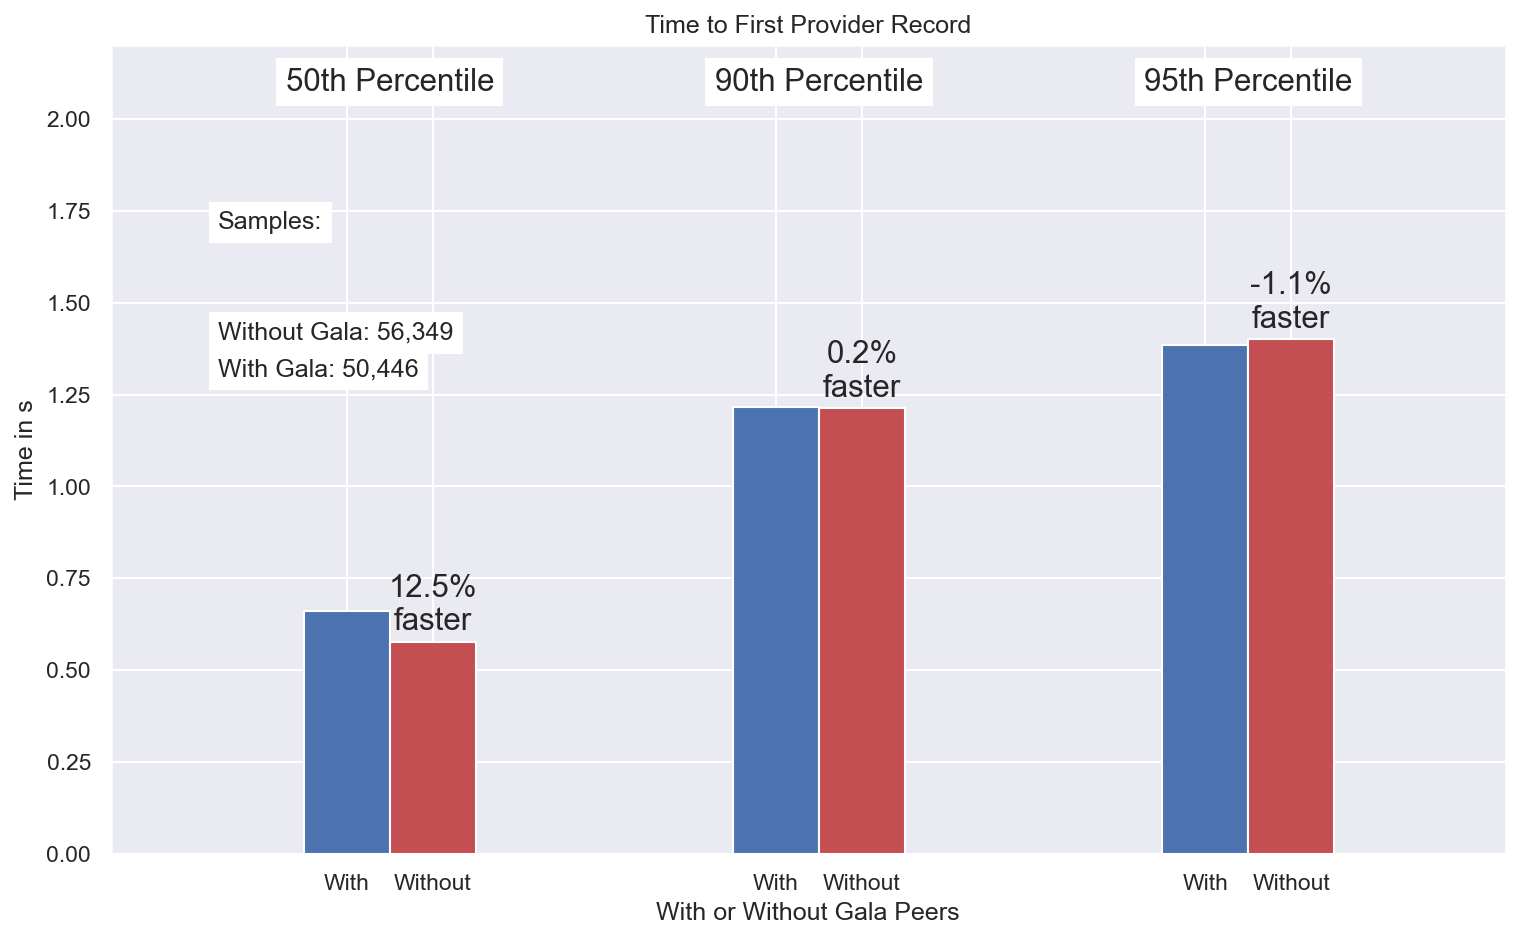

In [14]:
width = 0.2

fig, ax = plt.subplots(figsize=[12, 7], dpi=150)

xticks = []
labels = []
retrievals_by_galas = {
    "with": pd.DataFrame.from_dict(df_retrievals_dict_map["with_gala"]),
    "without": pd.DataFrame.from_dict(df_retrievals_dict_map["without_gala"]),
}
min_date = '2023-02-10'
sample_counts = {}
for i, percentile in enumerate([50, 90, 95]):

    dat = retrievals_by_galas["with"]
    dat = dat[dat["started_at"] >= min_date]
    dat = dat["find_first_provider_duration"]
    sample_counts["With Gala"] = len(dat)
    with_percentile = np.percentile(dat, percentile)
    ax.bar(i - width, with_percentile, width, label="With Galas", color="b")

    dat = retrievals_by_galas["without"]
    dat = dat[dat["started_at"] >= min_date]
    dat = dat["find_first_provider_duration"]
    sample_counts["Without Gala"] = len(dat)
    without_percentile = np.percentile(dat, percentile)
    ax.bar(i, without_percentile, width, label="Without Galas", color="r")

    ax.text(i, without_percentile + 0.1, f"{1- without_percentile / with_percentile:.1%}\nfaster", ha="center", va="center", size=15)

    ax.text(i-width/2, 2.1, f"{percentile}th Percentile", ha="center", va="center", size=15,
            bbox=dict(fc="w", lw=1))
    xticks += [i - width, i]
    labels += ["With", "Without"]

for i, key in enumerate(sample_counts):
    ax.text(-0.5, 0.1*i + 1.3, f"{key}: {format(sample_counts[key], ',')}",bbox=dict(fc="w", lw=1))

ax.text(-0.5, 0.1*4 + 1.3, "Samples:",bbox=dict(fc="w", lw=1))

ax.set_title(f"Time to First Provider Record")
ax.set_xlabel("With or Without Gala Peers")
ax.set_ylabel("Time in s")
ax.set_xticks(xticks, labels)
ax.set_xlim(-0.75, 2.5)
ax.set_ylim(0, 2.2)

ax.set_xticks(xticks, labels)


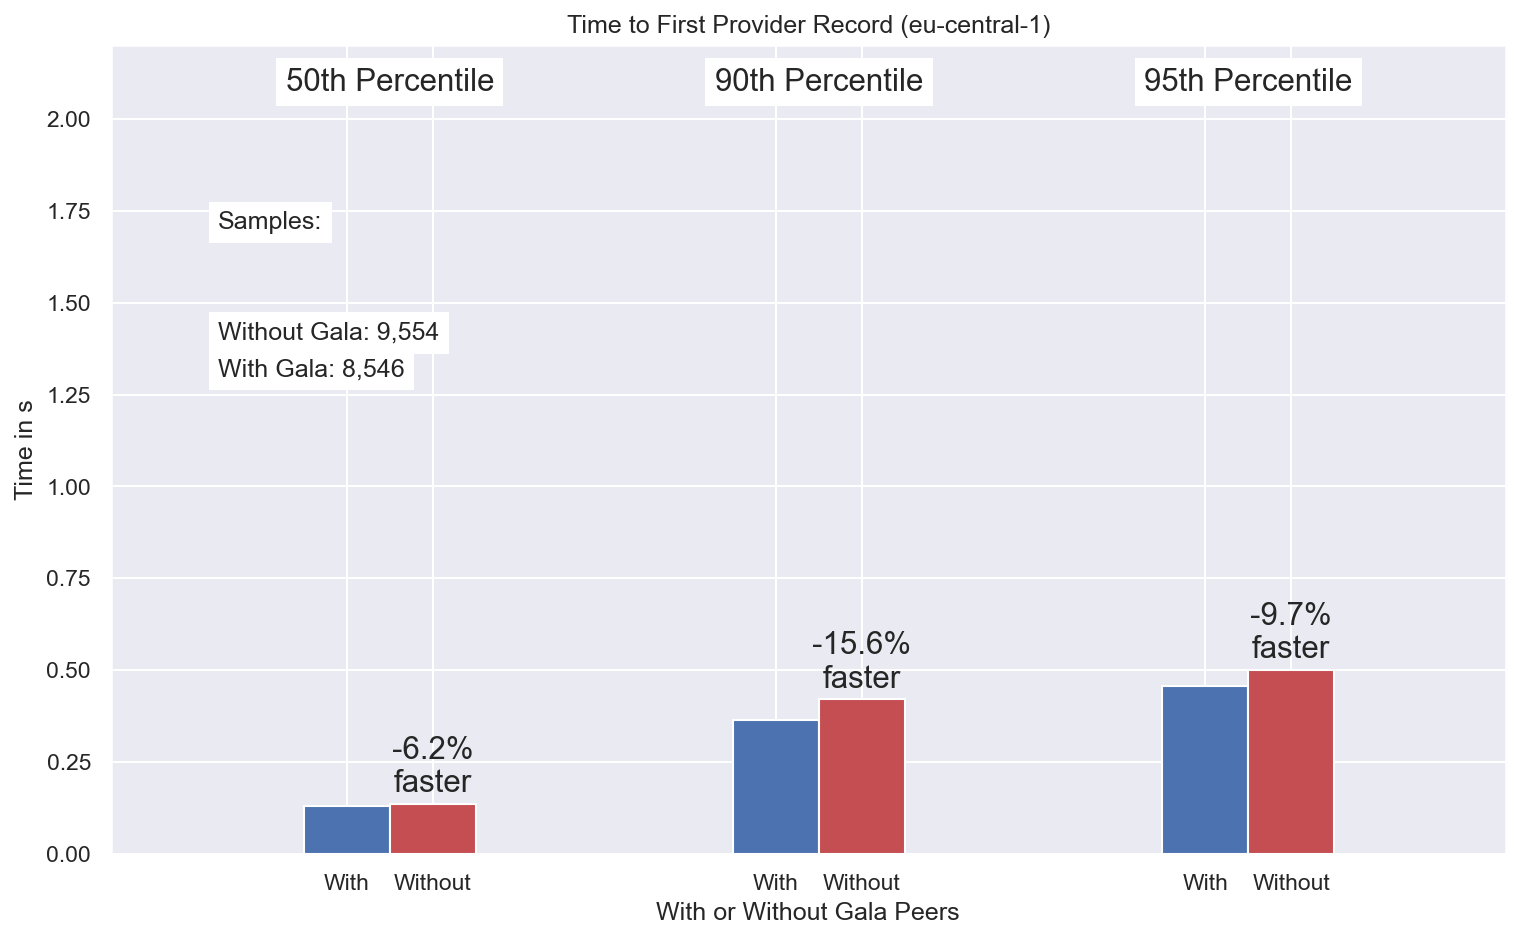

In [15]:
import datetime

width = 0.2

fig, ax = plt.subplots(figsize=[12, 7], dpi=150)

xticks = []
labels = []
retrievals_by_galas = {
    "with": pd.DataFrame.from_dict(df_retrievals_dict_map["with_gala"]),
    "without": pd.DataFrame.from_dict(df_retrievals_dict_map["without_gala"]),
}
sample_counts = {}
for i, percentile in enumerate([50, 90, 95]):

    dat = retrievals_by_galas["with"]
    dat = dat[dat["started_at"] >= '2023-02-14']
    dat = dat[dat["region"] == "eu_central_1"]
    dat = dat["find_first_provider_duration"]
    sample_counts["With Gala"] = len(dat)
    with_percentile = np.percentile(dat, percentile)
    ax.bar(i - width, with_percentile, width, label="With Galas", color="b")

    dat = retrievals_by_galas["without"]
    dat = dat[dat["started_at"] >= '2023-02-14']
    dat = dat[dat["region"] == "eu_central_1"]
    dat = dat["find_first_provider_duration"]
    sample_counts["Without Gala"] = len(dat)
    without_percentile = np.percentile(dat, percentile)
    ax.bar(i, without_percentile, width, label="Without Galas", color="r")

    ax.text(i, without_percentile + 0.1, f"{1- without_percentile / with_percentile:.1%}\nfaster", ha="center", va="center", size=15)

    ax.text(i-width/2, 2.1, f"{percentile}th Percentile", ha="center", va="center", size=15,
            bbox=dict(fc="w", lw=1))
    xticks += [i - width, i]
    labels += ["With", "Without"]

for i, key in enumerate(sample_counts):
    ax.text(-0.5, 0.1*i + 1.3, f"{key}: {format(sample_counts[key], ',')}",bbox=dict(fc="w", lw=1))

ax.text(-0.5, 0.1*4 + 1.3, "Samples:",bbox=dict(fc="w", lw=1))

ax.set_title(f"Time to First Provider Record (eu-central-1)")
ax.set_xlabel("With or Without Gala Peers")
ax.set_ylabel("Time in s")
ax.set_xticks(xticks, labels)
ax.set_xlim(-0.75, 2.5)
ax.set_ylim(0, 2.2)

ax.set_xticks(xticks, labels)


/var/folders/5v/11vhc3kx5yxc2kr1whd5hyxc0000gn/T/ipykernel_27887/476355342.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = grp.quantile([.5, .9, .95])
/var/folders/5v/11vhc3kx5yxc2kr1whd5hyxc0000gn/T/ipykernel_27887/476355342.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = grp.quantile([.5, .9, .95])


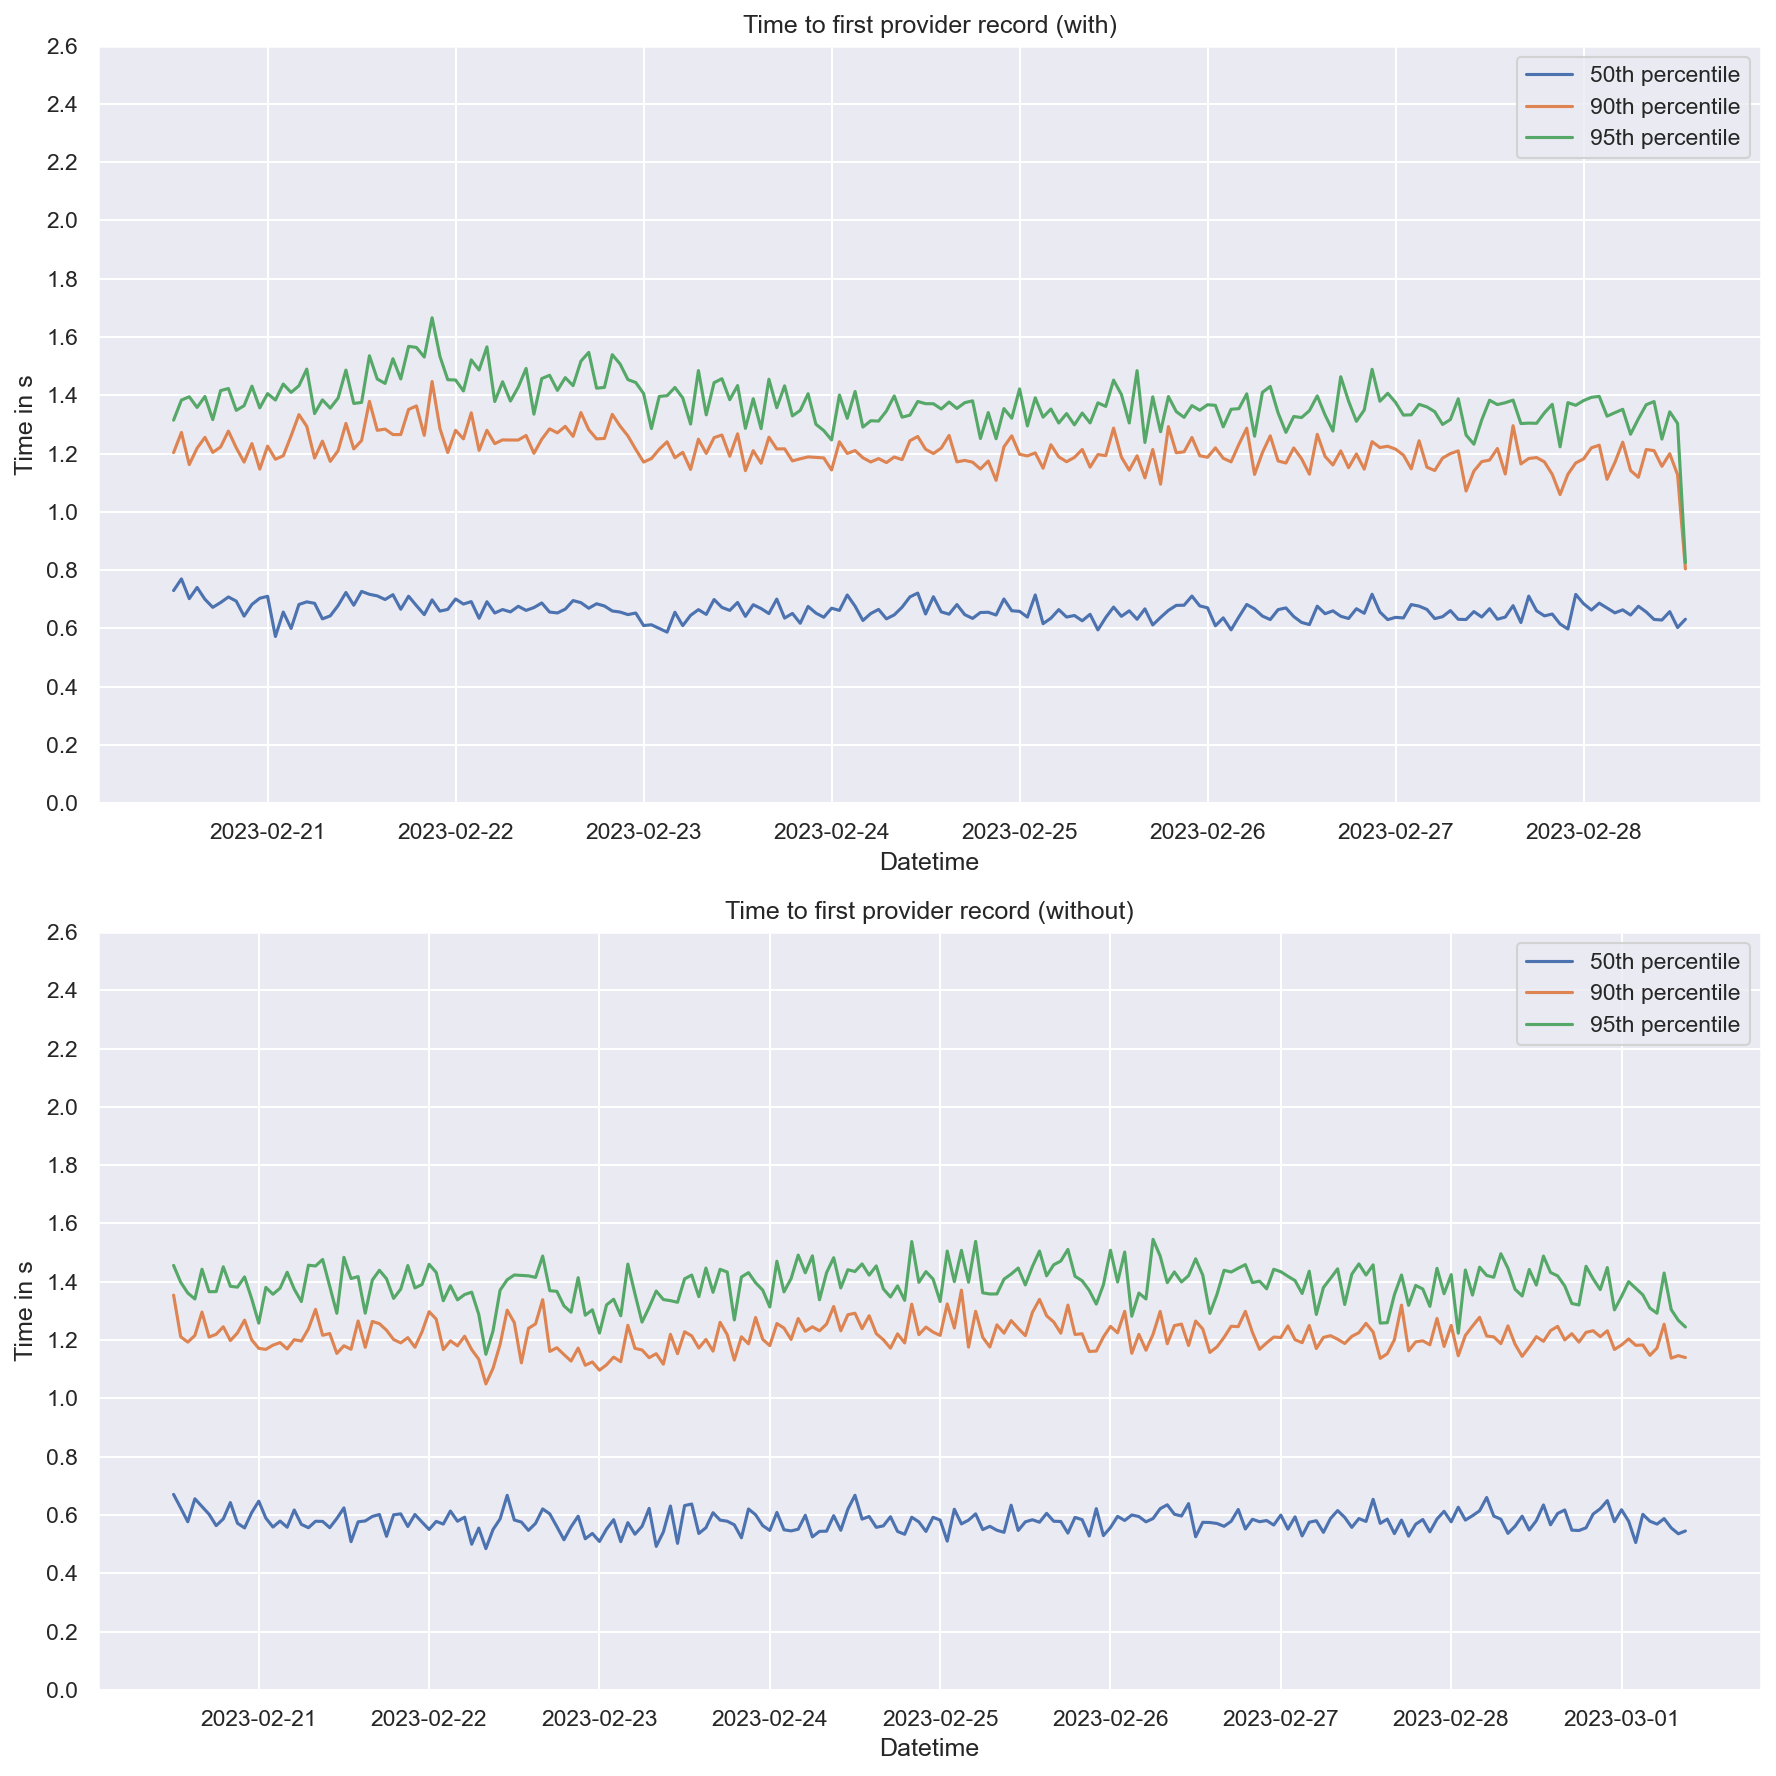

In [17]:
fig, ax = plt.subplots(2, 1, figsize=[12, 12], dpi=150)

retrievals_by_galas = {
    "with": pd.DataFrame.from_dict(df_retrievals_dict_map["with_gala"]),
    "without": pd.DataFrame.from_dict(df_retrievals_dict_map["without_gala"]),
}

for idx, key in enumerate(retrievals_by_galas.keys()):
    ax = fig.axes[idx]
    data = retrievals_by_galas[key]
    grp = data.groupby(by=[data.started_at.map(lambda started_at: started_at.replace(minute=0, second=0, microsecond=0))])
    grp.find_first_provider_duration.quantile([.5, .9, .95])
    df = grp.quantile([.5, .9, .95])
    df.reset_index(inplace=True)

    percentiles = [50, 90, 95]
    for percentile in percentiles:
        dat = df[df["level_1"] == percentile / 100]
        ax.plot(dat["started_at"], dat["find_first_provider_duration"], label=f"{percentile}th percentile")

    # ax.axvline(np.datetime64("2023-02-01 22:00:00"), 0, 0.9)
    # ax.text(np.datetime64("2023-02-02"), 2.3, "Gala Update")
    ax.set_ylabel("Time in s")
    ax.set_xlabel("Datetime")
    ax.set_title(f"Time to first provider record ({key})")
    ax.set_ylim(0, 2.6)
    ax.set_yticks(np.arange(0, 2.7, 0.2))
    ax.legend()
fig.set_tight_layout(True)

In [16]:
times_df = pd.read_csv('../data/find-times.csv', names=["started_at", "find_first_provider_duration", "ok", "cid"], parse_dates=["started_at"])

In [17]:
times_df.started_at.map(lambda started_at: started_at.replace(minute=0, second=0, microsecond=0, nanosecond=0))

0     2023-02-02 17:00:00+00:00
1     2023-02-02 17:00:00+00:00
2     2023-02-02 17:00:00+00:00
3     2023-02-02 17:00:00+00:00
4     2023-02-02 17:00:00+00:00
                 ...           
673   2023-02-07 12:00:00+00:00
674   2023-02-07 12:00:00+00:00
675   2023-02-07 12:00:00+00:00
676   2023-02-07 12:00:00+00:00
677   2023-02-07 13:00:00+00:00
Name: started_at, Length: 678, dtype: datetime64[ns, UTC]

/var/folders/5v/11vhc3kx5yxc2kr1whd5hyxc0000gn/T/ipykernel_11311/4194395763.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = grp.quantile([.5, .9, .95])
/var/folders/5v/11vhc3kx5yxc2kr1whd5hyxc0000gn/T/ipykernel_11311/4194395763.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = grp.quantile([.5, .9, .95])


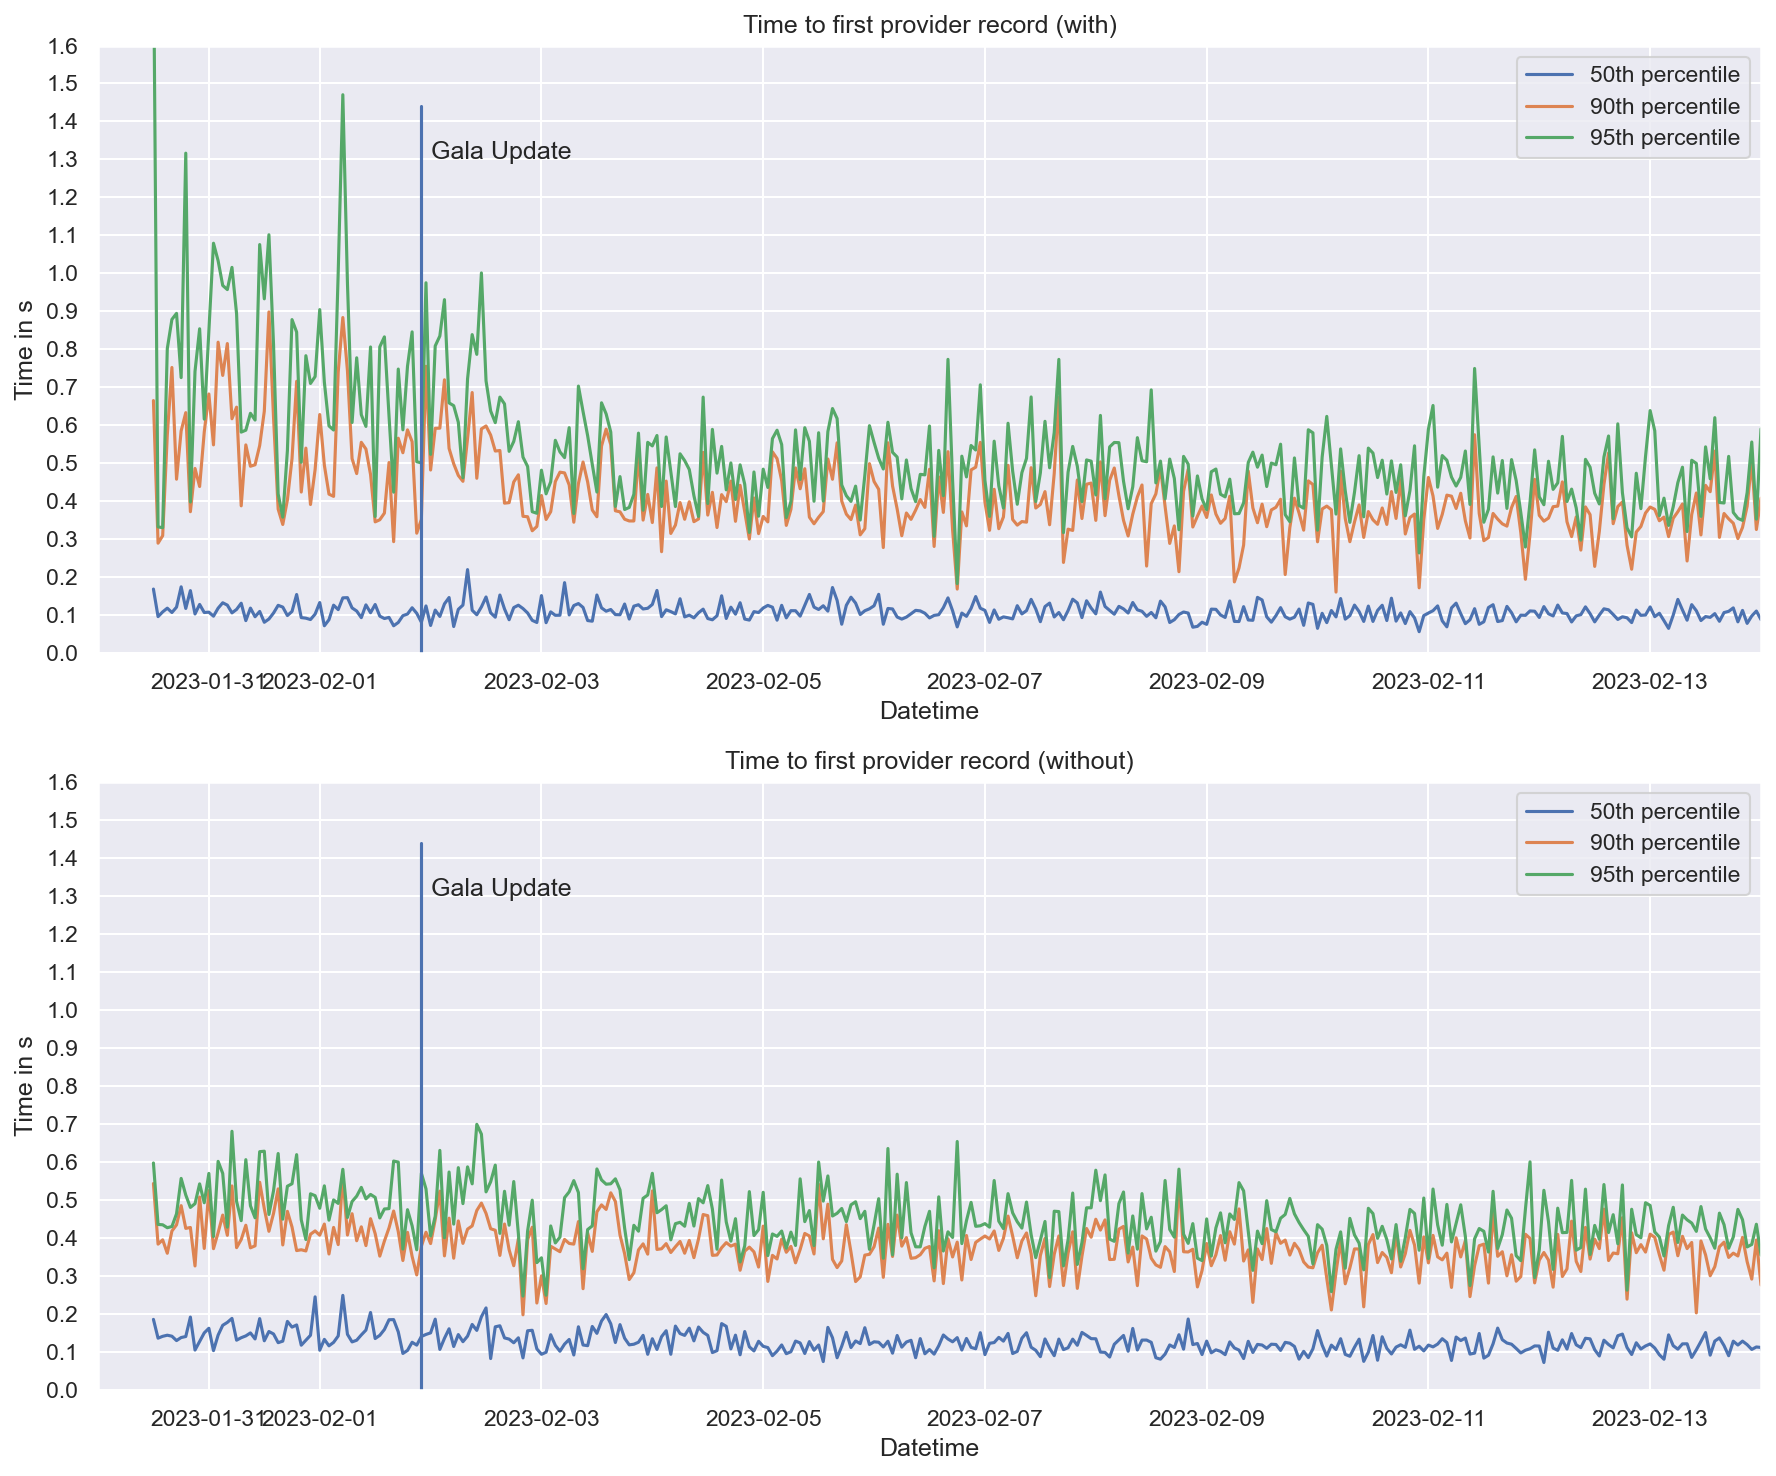

In [18]:


fig, ax = plt.subplots(2, 1, figsize=[12, 10], dpi=150)

retrievals_by_galas = {
    "with": pd.DataFrame.from_dict(df_retrievals_dict_map["with_gala"]),
    "without": pd.DataFrame.from_dict(df_retrievals_dict_map["without_gala"]),
}

for idx, key in enumerate(retrievals_by_galas.keys()):
    ax = fig.axes[idx]
    data = retrievals_by_galas[key]
    data = data[(data["region"] == "eu_central_1")]
    data = data[data["started_at"] >= "2023-01-30 12:00:00"]
    grp = data.groupby(by=[data.started_at.map(lambda started_at: started_at.replace(minute=0, second=0, microsecond=0, nanosecond=0))])
    grp.find_first_provider_duration.quantile([.5, .9, .95])
    df = grp.quantile([.5, .9, .95])
    df.reset_index(inplace=True)

    percentiles = [50, 90, 95]
    for percentile in percentiles:
        dat = df[df["level_1"] == percentile / 100]
        ax.plot(dat["started_at"], dat["find_first_provider_duration"], label=f"{percentile}th percentile")

    ax.axvline(np.datetime64("2023-02-01 22:00:00"), 0, 0.9)
    ax.text(np.datetime64("2023-02-02"), 1.3, "Gala Update")
    ax.set_ylabel("Time in s")
    ax.set_xlabel("Datetime")
    ax.set_title(f"Time to first provider record ({key})")
    ax.set_ylim(0, 1.6)
    ax.set_xlim(np.datetime64("2023-01-30 00:00:00"), np.datetime64("2023-02-14 00:00:00"))
    ax.set_yticks(np.arange(0, 1.7, 0.1))
    ax.legend()


fig.set_tight_layout(True)

KeyError: 'alpha_20'

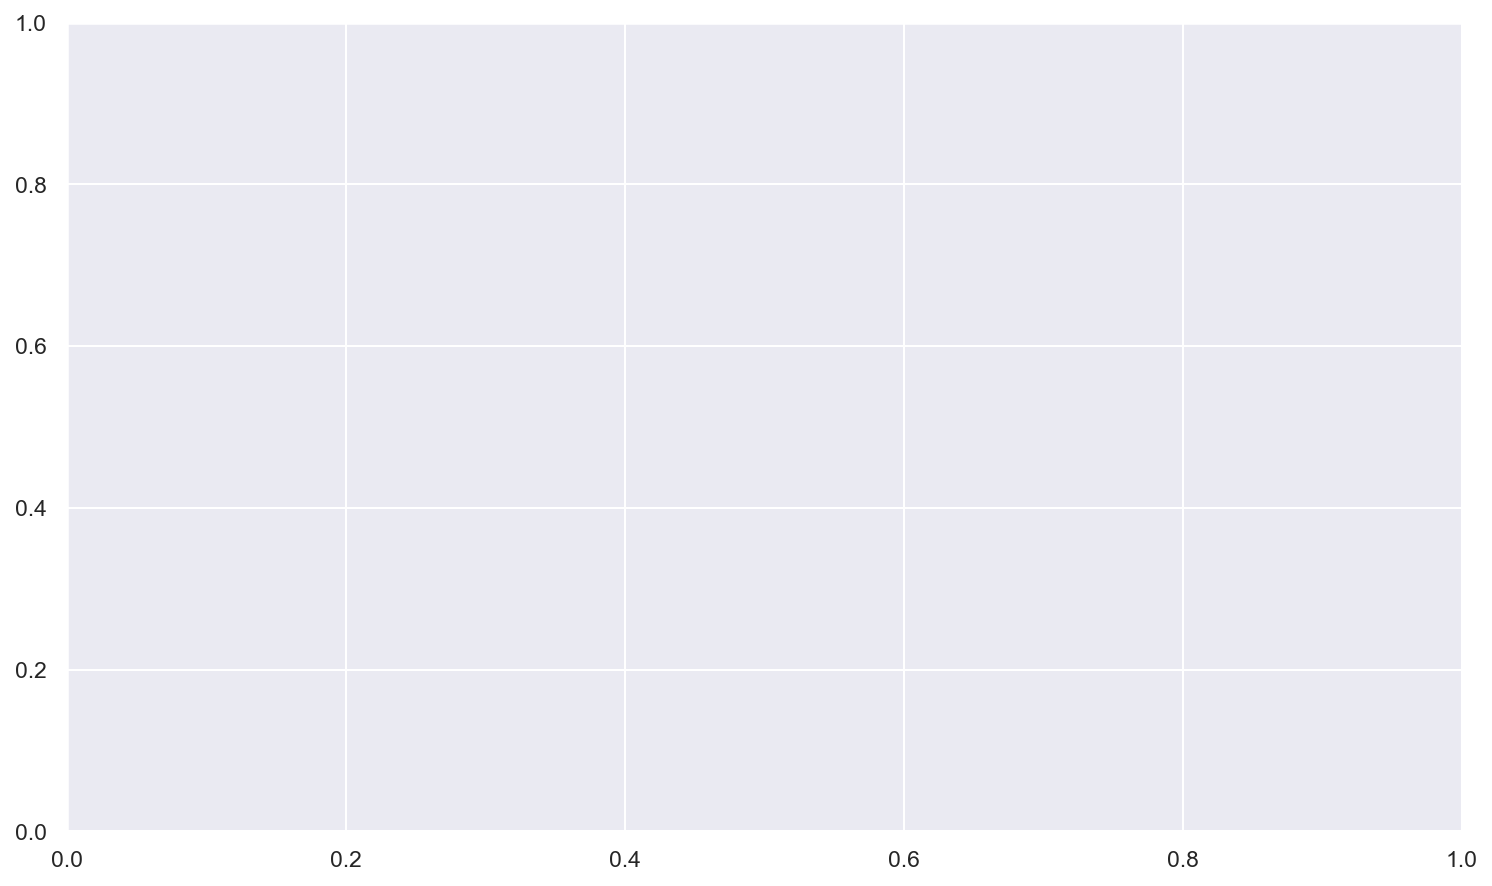

In [19]:
width = 0.2

fig, ax = plt.subplots(figsize=[12, 7], dpi=150)

xticks = []
labels = []
retrievals_by_galas = {
    "with": pd.DataFrame.from_dict(df_retrievals_dict_map["with_gala"]),
    "without": pd.DataFrame.from_dict(df_retrievals_dict_map["without_gala"]),
    "alpha_20": pd.DataFrame.from_dict(df_retrievals_dict_map["alpha_20"]),
}
min_date = retrievals_by_galas["alpha_20"]["started_at"].min()
region = "eu_central_1"
sample_counts = {}
for i, percentile in enumerate([50, 90, 95]):

    sample_counts["CircleCI"] = len(times)
    circleci_percentile = np.percentile(times, percentile)
    ax.bar(i - 2 * width, circleci_percentile, width, label="CircleCI", color="y")

    dat = retrievals_by_galas["with"]
    dat = dat[dat["region"] == region]
    dat = dat[dat["started_at"] >= '2023-01-31']
    dat = dat[dat["started_at"] <= '2023-02-02']
    dat = dat["find_first_provider_duration"]
    sample_counts["With Gala"] = len(dat)
    with_percentile = np.percentile(dat, percentile)
    ax.bar(i - width, with_percentile, width, label="With Galas", color="b")

    dat = retrievals_by_galas["without"]
    dat = dat[dat["region"] == region]
    dat = dat[dat["started_at"] >= '2023-01-31']
    dat = dat[dat["started_at"] <= '2023-02-02']
    dat = dat["find_first_provider_duration"]
    sample_counts["Without Gala"] = len(dat)
    without_percentile = np.percentile(dat, percentile)
    ax.bar(i, without_percentile, width, label="Without Galas", color="r")

    dat = retrievals_by_galas["alpha_20"]
    dat = dat[dat["region"] == region]
    dat = dat[dat["started_at"] >= '2023-01-31']
    dat = dat[dat["started_at"] <= '2023-02-02']
    dat = dat["find_first_provider_duration"]
    sample_counts["Alpha 20"] = len(dat)
    alpha_20 = np.percentile(dat, percentile)
    ax.bar(i + width, alpha_20, width, label="Alpha 20", color="g")
    ax.text(i, without_percentile + 0.1, f"{1- without_percentile / with_percentile:.1%}\nfaster", ha="center", va="center", size=15)
    ax.text(i + width, alpha_20 + 0.1, f"{1- alpha_20 / with_percentile:.1%}\nfaster", ha="center", va="center", size=15)

    ax.text(i-width/2, 2.1, f"{percentile}th Percentile", ha="center", va="center", size=15,
            bbox=dict(fc="w", lw=1))
    xticks += [i -2*width, i - width, i, i + width]
    labels += ["CircleCI", "With", "Without", "Alpha 20"]

for i, key in enumerate(sample_counts):
    ax.text(-0.5, 0.1*i + 1.3, f"{key}: {format(sample_counts[key], ',')}",bbox=dict(fc="w", lw=1))

ax.text(-0.5, 0.1*4 + 1.3, "Samples:",bbox=dict(fc="w", lw=1))

ax.set_title(f"Time to First Provider Record (only eu-central-1)")
ax.set_xlabel("CircleCI Script, With or Without Gala Peers, and alpha=20")
ax.set_ylabel("Time in s")
ax.set_xticks(xticks, labels)
ax.set_xlim(-0.75, 2.5)
ax.set_ylim(0, 2.2)

ax.set_xticks(xticks, labels)


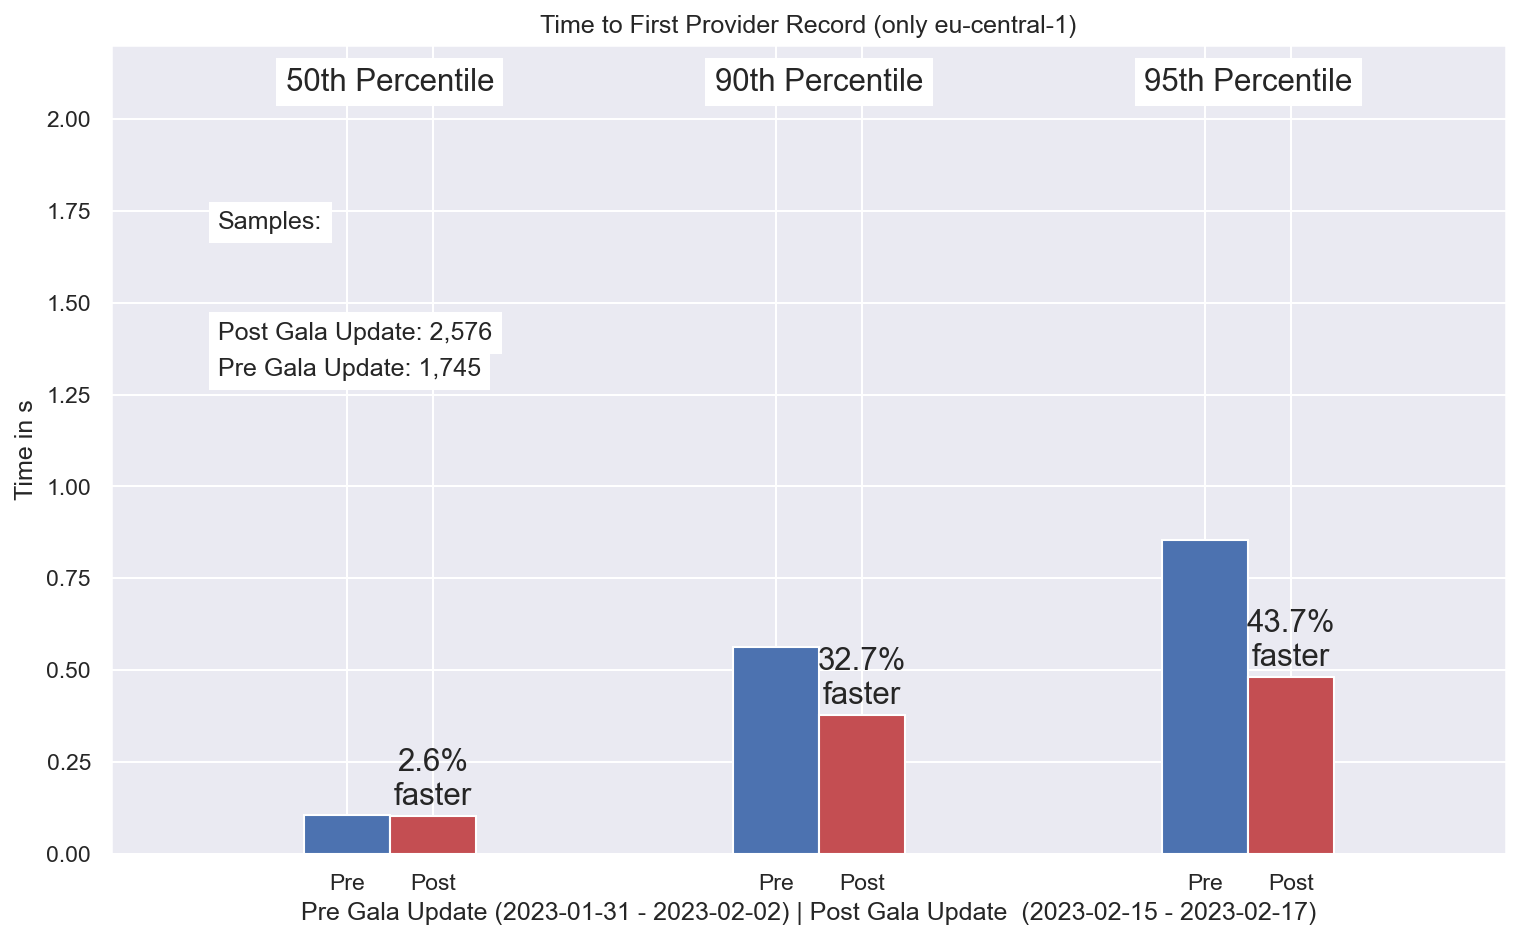

In [21]:
width = 0.2

fig, ax = plt.subplots(figsize=[12, 7], dpi=150)

xticks = []
labels = []
retrievals_by_galas = {
    "with": pd.DataFrame.from_dict(df_retrievals_dict_map["with_gala"]),
    "without": pd.DataFrame.from_dict(df_retrievals_dict_map["without_gala"]),
}
region = "eu_central_1"
sample_counts = {}
for i, percentile in enumerate([50, 90, 95]):

    dat = retrievals_by_galas["with"]
    dat = dat[dat["region"] == region]
    dat = dat[dat["started_at"] >= '2023-01-31']
    dat = dat[dat["started_at"] <= '2023-02-02']
    dat = dat["find_first_provider_duration"]
    sample_counts["Pre Gala Update"] = len(dat)
    with_percentile = np.percentile(dat, percentile)
    ax.bar(i - width, with_percentile, width, label="With Galas (pre update)", color="b")

    dat = retrievals_by_galas["with"]
    dat = dat[dat["region"] == region]
    dat = dat[dat["started_at"] >= '2023-02-15']
    dat = dat["find_first_provider_duration"]
    sample_counts["Post Gala Update"] = len(dat)
    without_percentile = np.percentile(dat, percentile)
    ax.bar(i, without_percentile, width, label="With Galas (post update", color="r")

    ax.text(i, without_percentile + 0.1, f"{1- without_percentile / with_percentile:.1%}\nfaster", ha="center", va="center", size=15)
    ax.text(i-width/2, 2.1, f"{percentile}th Percentile", ha="center", va="center", size=15,
            bbox=dict(fc="w", lw=1))
    xticks += [ i - width, i]
    labels += ["Pre", "Post"]

for i, key in enumerate(sample_counts):
    ax.text(-0.5, 0.1*i + 1.3, f"{key}: {format(sample_counts[key], ',')}",bbox=dict(fc="w", lw=1))

ax.text(-0.5, 0.1*4 + 1.3, "Samples:",bbox=dict(fc="w", lw=1))

ax.set_title(f"Time to First Provider Record (only eu-central-1)")
ax.set_xlabel("Pre Gala Update (2023-01-31 - 2023-02-02) | Post Gala Update  (2023-02-15 - 2023-02-17)")
ax.set_ylabel("Time in s")
ax.set_xticks(xticks, labels)
ax.set_xlim(-0.75, 2.5)
ax.set_ylim(0, 2.2)

ax.set_xticks(xticks, labels)
